# Convolutional Neural Network. Practice Exercise

Again we use the toxicity data for the exercise task. However, this time the molecules are not in SMILES format, but the structures are stored as an image. **You will again predict the toxicity, but this time based on the image**.

In fact, this has [already been attempted](https://www.sciencedirect.com/science/article/abs/pii/S0169743919303417).

The images consist of `64 x 64` pixels. You will see that this is barely sufficient to see the molecular structure.  However, we are bound to the memory space provided by the university.
And a higher resolution does not change the underlying task.

## Restart the kernel before beginning the exercise!


In [1]:
import numpy as np
import torch
from torch import nn
from torch.utils import data
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import torchvision.transforms as T
def min_max(x):
    return (x - np.min(x)) / (np.max(x) - np.min(x))

First, divide the data into training set and test set. Important: the last column contains the information about the toxicity. So this is our variable to predict.

In [2]:
mol_img_data = torch.tensor(pd.read_csv('https://uni-muenster.sciebo.de/s/bUVM12XtVlQY6js/download',
                                        delimiter = ',',
                                        header = None).values,
                            dtype = torch.float32)

In [3]:
mol_img_data.shape

torch.Size([2246, 4097])

In [4]:
# mol_img_data = torch.tensor(pd.read_csv('https://uni-muenster.sciebo.de/s/bUVM12XtVlQY6js/download',
#                                         delimiter = ',',
#                                         header = None).values,
#                             dtype = torch.float32)

train, test=train_test_split(mol_img_data, test_size=0.2,train_size=0.8, random_state=1234)

train_x = train[:, :-1]
train_y = train[:, -1]
test_x = test[:, :-1]
test_y = test[:, -1]


print(train_x.shape, train_y.shape)

torch.Size([1796, 4096]) torch.Size([1796])


This is how pixelated the images look:

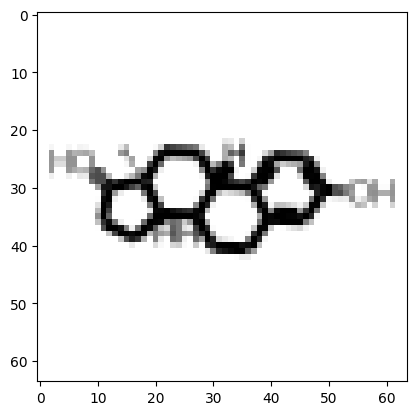

In [5]:
plt.imshow(train_x[10,:].view(64,64), cmap= "gray")

Next, convert the test and training set. Remember that the dimensions should look like this. `Number of Images, Number of Channels, Height, Width`.

In [6]:
train_x = train_x.view(-1, 1, 64, 64)
test_x = test_x.view(-1, 1, 64, 64)
print(train_x.shape, train_y.shape)

torch.Size([1796, 1, 64, 64]) torch.Size([1796])


In [7]:
torch_train = data.TensorDataset(train_x, train_y)
train_loader = data.DataLoader(torch_train, batch_size=32)

batch_x, batch_y =next(iter(train_loader))
print(batch_x.shape, batch_y.shape)

torch.Size([32, 1, 64, 64]) torch.Size([32])


If you have done everything right so far, `batch_x` should have the dimensions `[32, 1, 64, 64]` and `batch_y` should have the dimensions `[32]`. Add at least 2 more convolution layers to the network. Make sure you also use pooling layers and non-linear activation functions.

In [8]:
cnn = nn.Sequential(nn.Conv2d(in_channels=1, out_channels=3, kernel_size=3, padding=1),
                    nn.ReLU(),
                    nn.MaxPool2d(kernel_size=2, stride=2),
                    nn.Conv2d(in_channels=3, out_channels=6, kernel_size=3, padding=1),
                    nn.ReLU(),
                    nn.MaxPool2d(kernel_size=2, stride=2),
                   )

In [9]:
cnn(batch_x).shape

torch.Size([32, 6, 16, 16])

Now add a `flatten` layer. From which dimension do we start to add the values together?

In [10]:
cnn.add_module("flatten",nn.Flatten(1))

In [11]:
cnn(batch_x).shape

torch.Size([32, 1536])

At last add a `BatchNorm`, `Dropout` and `Linear` layer. Make sure you use the correct input/output dimensions.

In [12]:
cnn.add_module("bn", nn.BatchNorm1d(1536))
cnn.add_module("dp", nn.Dropout(0.2))
cnn.add_module("fc", nn.Linear(1536,1))

In [13]:
cnn(batch_x).shape

torch.Size([32, 1])

The `shape` should now be `[32, 1]`. Fill in the rest of the training loop.

In [15]:
loss_function = nn.BCEWithLogitsLoss()
update =  torch.optim.Adam(cnn.parameters(), lr =0.0003)
EPOCHS = 30


for i in range(EPOCHS):
    loss_list = []

    cnn.train()
    for minibatch in train_loader:
        images, labels = minibatch
        update.zero_grad()
        output = cnn(images)
        loss   = loss_function(output.squeeze(), labels)
        loss.backward()
        loss_list.append(loss.item())
        update.step()
    cnn.eval()

    # Training Evaluation
    output = cnn(train_x)
    train_acc = torch.sum((output>0).squeeze().int() == train_y)/train_y.shape[0]
    # Test Evaluation
    output = cnn(test_x)
    loss   = loss_function(output.squeeze(), test_y)
    test_acc = torch.sum((output>0).squeeze().int() == test_y)/test_y.shape[0]

    print(
        "Training Loss: %.2f Training Accuracy: %.2f | Test Loss: %.2f  Test Accuracy: %.2f"
        % (np.mean(loss_list), train_acc, loss.item(),test_acc )
    )

Training Loss: 0.69 Training Accuracy: 0.67 | Test Loss: 0.66  Test Accuracy: 0.65
Training Loss: 0.62 Training Accuracy: 0.69 | Test Loss: 0.64  Test Accuracy: 0.66
Training Loss: 0.58 Training Accuracy: 0.72 | Test Loss: 0.64  Test Accuracy: 0.66
Training Loss: 0.56 Training Accuracy: 0.73 | Test Loss: 0.64  Test Accuracy: 0.68
Training Loss: 0.55 Training Accuracy: 0.74 | Test Loss: 0.63  Test Accuracy: 0.68
Training Loss: 0.54 Training Accuracy: 0.73 | Test Loss: 0.65  Test Accuracy: 0.66
Training Loss: 0.52 Training Accuracy: 0.75 | Test Loss: 0.64  Test Accuracy: 0.69
Training Loss: 0.52 Training Accuracy: 0.76 | Test Loss: 0.63  Test Accuracy: 0.69
Training Loss: 0.50 Training Accuracy: 0.77 | Test Loss: 0.64  Test Accuracy: 0.68
Training Loss: 0.50 Training Accuracy: 0.76 | Test Loss: 0.66  Test Accuracy: 0.68
Training Loss: 0.49 Training Accuracy: 0.73 | Test Loss: 0.70  Test Accuracy: 0.63
Training Loss: 0.49 Training Accuracy: 0.78 | Test Loss: 0.66  Test Accuracy: 0.69
Trai

As you can see, this works only moderately. It definitely works better with fingerprints.
Generally, it is more difficult to train CNNs than simpler neural networks.
Furthermore, drawing molecules is very inefficient compared to calculation of SMILES or fingerprints/descriptors.

In our case, one could argue that our model could also learn better if we had larger and more colorful images. This is probably true. But even in the above paper, CNNs simply could not beat networks with fingerprints.
It can be said that images are not an adequate representation of molecules. At least not for machine learning.

This is not to say that it cannot be useful to train CNNs on images of molecules.
For example, networks that recognize structures and output the appropriate SMILES. This can be used to quickly search patents and chemical publications.


For example here:
https://jcheminf.biomedcentral.com/articles/10.1186/s13321-021-00538-8